In [106]:
import numpy as np
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as XGB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings("ignore")

In [107]:
df = pd.read_csv('important_financials.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Name,Year,Total income,Net sales,Sales / Net fixed assets,Change in stock,Total expenses,Profit after tax,PBDITA,PBIT,...,Debt/Net Income,Debt/Net Sales,Market Value Equity,NWC/TA,Retained Earnings/TA,PBIT/TA,MVE/Debt,Net sales/TA,Altman_Z,P(Default)
0,20 MICRONS LTD.,0,3097.0,2888.8,204.9425,51.2,3146.9,1.3,322.1,217.8,...,1246.846154,0.561098,4028.5353,0.307074,0.000567,0.224067,1.491222,0.900583,2.923513,0.002
1,20 MICRONS LTD.,1,3316.2,3116.7,227.7801,21.3,3378.2,-40.7,301.7,203.2,...,-38.014742,0.496422,3942.1761,0.237963,-0.017320,0.203830,1.528765,0.947383,2.900621,0.002
2,20 MICRONS LTD.,2,3527.6,3338.3,249.5431,8.2,3442.4,93.4,449.3,344.3,...,16.622056,0.465057,3973.0331,0.226455,0.039123,0.339943,1.535472,0.998803,3.139795,0.001
3,20 MICRONS LTD.,3,3741.8,3569.9,239.0117,-42.8,3567.4,131.6,519.6,421.4,...,11.047112,0.407238,4449.9837,0.258453,0.050320,0.379806,1.836560,0.975010,3.500147,0.000
4,20 MICRONS LTD.,4,3922.0,3845.7,237.2036,7.2,3770.4,158.8,545.0,453.6,...,8.149874,0.336532,4576.0911,0.241780,0.052821,0.393016,2.121507,1.009715,3.818839,0.000


Perform imputations to the data here.

In [108]:
df_imputed = df.copy()
df_imputed.drop(columns = ['Revenue'],inplace = True)
df_imputed.head()

,Name,Year,Total income,Net sales,Sales / Net fixed assets,Change in stock,Total expenses,Profit after tax,PBDITA,PBIT,...,Debt/Net Income,Debt/Net Sales,Market Value Equity,NWC/TA,Retained Earnings/TA,PBIT/TA,MVE/Debt,Net sales/TA,Altman_Z,P(Default)
0,20 MICRONS LTD.,0,3097.0,2888.8,204.9425,51.2,3146.9,1.3,322.1,217.8,...,1246.846154,0.561098,4028.5353,0.307074,0.000567,0.224067,1.491222,0.900583,2.923513,0.002
1,20 MICRONS LTD.,1,3316.2,3116.7,227.7801,21.3,3378.2,-40.7,301.7,203.2,...,-38.014742,0.496422,3942.1761,0.237963,-0.017320,0.203830,1.528765,0.947383,2.900621,0.002
2,20 MICRONS LTD.,2,3527.6,3338.3,249.5431,8.2,3442.4,93.4,449.3,344.3,...,16.622056,0.465057,3973.0331,0.226455,0.039123,0.339943,1.535472,0.998803,3.139795,0.001
3,20 MICRONS LTD.,3,3741.8,3569.9,239.0117,-42.8,3567.4,131.6,519.6,421.4,...,11.047112,0.407238,4449.9837,0.258453,0.050320,0.379806,1.836560,0.975010,3.500147,0.000
4,20 MICRONS LTD.,4,3922.0,3845.7,237.2036,7.2,3770.4,158.8,545.0,453.6,...,8.149874,0.336532,4576.0911,0.241780,0.052821,0.393016,2.121507,1.009715,3.818839,0.000


In [109]:
df_imputed = df_imputed.groupby(['Name']).apply(lambda g: g.ffill()).reset_index(drop=True)
df_imputed = df_imputed.groupby(['Name']).apply(lambda g: g.bfill()).reset_index(drop=True)
df_imputed.head()

,Name,Year,Total income,Net sales,Sales / Net fixed assets,Change in stock,Total expenses,Profit after tax,PBDITA,PBIT,...,Debt/Net Income,Debt/Net Sales,Market Value Equity,NWC/TA,Retained Earnings/TA,PBIT/TA,MVE/Debt,Net sales/TA,Altman_Z,P(Default)
0,20 MICRONS LTD.,0,3097.0,2888.8,204.9425,51.2,3146.9,1.3,322.1,217.8,...,1246.846154,0.561098,4028.5353,0.307074,0.000567,0.224067,1.491222,0.900583,2.923513,0.002
1,20 MICRONS LTD.,1,3316.2,3116.7,227.7801,21.3,3378.2,-40.7,301.7,203.2,...,-38.014742,0.496422,3942.1761,0.237963,-0.017320,0.203830,1.528765,0.947383,2.900621,0.002
2,20 MICRONS LTD.,2,3527.6,3338.3,249.5431,8.2,3442.4,93.4,449.3,344.3,...,16.622056,0.465057,3973.0331,0.226455,0.039123,0.339943,1.535472,0.998803,3.139795,0.001
3,20 MICRONS LTD.,3,3741.8,3569.9,239.0117,-42.8,3567.4,131.6,519.6,421.4,...,11.047112,0.407238,4449.9837,0.258453,0.050320,0.379806,1.836560,0.975010,3.500147,0.000
4,20 MICRONS LTD.,4,3922.0,3845.7,237.2036,7.2,3770.4,158.8,545.0,453.6,...,8.149874,0.336532,4576.0911,0.241780,0.052821,0.393016,2.121507,1.009715,3.818839,0.000


In [110]:
df_imputed = df_imputed.drop(columns = ['Name'])
df_imputed.fillna(df_imputed.mean(), inplace=True)
print(df_imputed.isnull().sum())

Year                                          0
Total income                                  0
Net sales                                     0
Sales / Net fixed assets                      0
Change in stock                               0
Total expenses                                0
Profit after tax                              0
PBDITA                                        0
PBIT                                          0
Cash profit                                   0
PAT as % of PBDITA                            0
Total liabilities                             0
Total capital                                 0
Reserves and funds                            0
Surplus/deficit as at the end of the year     0
Retained profits/losses during the year       0
Non-current liabilities                       0
Long term borrowings excl current portion     0
Current liabilities & provisions              0
Debt                                          0
Debt to equity ratio (times)            

In [111]:
corr_matrix = df_imputed.corr()
label_corr = corr_matrix['Label'].sort_values(ascending = False)
label_corr.head(20)

Label                                         1.000000
P(Default)                                    0.049926
Current liabilities & provisions              0.023897
Debt to equity ratio (times)                  0.019382
Debt                                          0.008126
Long term borrowings excl current portion     0.006866
Non-current liabilities                       0.006616
Net fixed assets                              0.002496
Total capital                                 0.001784
Change in working capital liabilities         0.000625
NWC/TA                                        0.000530
Debt/Assets                                   0.000428
Net working capital (cost of sales method)    0.000403
Debt/Equity                                   0.000396
Market Value Equity                           0.000304
Altman_Z                                     -0.000225
MVE/Debt                                     -0.000266
Retained Earnings/TA                         -0.000435
Sales / Ne

In [112]:
df_imputed['Name'] = df['Name']
df_imputed.head()

,Year,Total income,Net sales,Sales / Net fixed assets,Change in stock,Total expenses,Profit after tax,PBDITA,PBIT,Cash profit,...,Debt/Net Sales,Market Value Equity,NWC/TA,Retained Earnings/TA,PBIT/TA,MVE/Debt,Net sales/TA,Altman_Z,P(Default),Name
0,0,3097.0,2888.8,204.9425,51.2,3146.9,1.3,322.1,217.8,94.6,...,0.561098,4028.5353,0.307074,0.000567,0.224067,1.491222,0.900583,2.923513,0.002,20 MICRONS LTD.
1,1,3316.2,3116.7,227.7801,21.3,3378.2,-40.7,301.7,203.2,41.7,...,0.496422,3942.1761,0.237963,-0.017320,0.203830,1.528765,0.947383,2.900621,0.002,20 MICRONS LTD.
2,2,3527.6,3338.3,249.5431,8.2,3442.4,93.4,449.3,344.3,175.3,...,0.465057,3973.0331,0.226455,0.039123,0.339943,1.535472,0.998803,3.139795,0.001,20 MICRONS LTD.
3,3,3741.8,3569.9,239.0117,-42.8,3567.4,131.6,519.6,421.4,249.6,...,0.407238,4449.9837,0.258453,0.050320,0.379806,1.836560,0.975010,3.500147,0.000,20 MICRONS LTD.
4,4,3922.0,3845.7,237.2036,7.2,3770.4,158.8,545.0,453.6,247.0,...,0.336532,4576.0911,0.241780,0.052821,0.393016,2.121507,1.009715,3.818839,0.000,20 MICRONS LTD.


In [113]:
y = df_imputed['Label']
X = df_imputed.drop(columns = ['Label','Name'])

In [114]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [115]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sm = SMOTE(sampling_strategy = 'minority', k_neighbors = 5, random_state = 42)
X_train_resampled,y_train_resampled = sm.fit_resample(X_train,y_train)
X_test_resampled,y_test_resampled = sm.fit_resample(X_test,y_test)

print(f"Oversampled Training Dataset : \n {y_train_resampled.value_counts()}")
print(f"Training Dataset : \n {y_train.value_counts()}")
print(f"Oversampled Testing Dataset : \n {y_test_resampled.value_counts()}")
print(f"Testing Dataset : \n {y_test.value_counts()}")

Oversampled Training Dataset : 
 Label
0    43467
1    43467
Name: count, dtype: int64
Training Dataset : 
 Label
0    43467
1      594
Name: count, dtype: int64
Oversampled Testing Dataset : 
 Label
0    10867
1    10867
Name: count, dtype: int64
Testing Dataset : 
 Label
0    10867
1      149
Name: count, dtype: int64


In [116]:
class_weight = np.sum(y_train == 0)/np.sum(y_train == 1)
classifiers = {
    "DT" : DecisionTreeClassifier(criterion='gini',
                                  max_depth = 10,
                                  min_samples_split=5,
                                  class_weight = 'balanced', 
                                  random_state = 42),
    
    "RF" : RandomForestClassifier(criterion='gini',
                                  n_estimators = 100, 
                                  max_depth = 10,
                                  min_samples_split = 5,
                                  class_weight = 'balanced',
                                  random_state=42),
    
    "XGB" : XGB.XGBClassifier(objective = "binary:logistic",
                              eval_metric = "aucpr",
                              use_label_encoder = False,
                              scale_pos_weight = class_weight,
                              subsample = 1.0,
                              n_estimators = 500,
                              reg_lambda = 10,
                              reg_alpha = 1,
                              min_child_weight = 3,
                              max_depth = 7,
                              learning_rate = 0.1,
                              gamma = 0,
                              colsample_bytree = 0.8,
                              random_state = 42),
    
    "LogReg" : LogisticRegression(class_weight = 'balanced',
                                  random_state = 42),
    
    "SVM" : LinearSVC(class_weight = 'balanced',
                      random_state=31,
                      loss = 'hinge',
                      fit_intercept=False)
} 

In [117]:
clf_dt = classifiers["DT"]
clf_rf = classifiers["RF"]
clf_xgb = classifiers["XGB"]
clf_lr = classifiers["LogReg"]
clf_svm = classifiers["SVM"]

In [118]:
def print_metrics(clf,y_test,y_pred):
    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred, average='macro')
    recall = metrics.recall_score(y_test,y_pred, average='macro')
    f1 = metrics.f1_score(y_test,y_pred, average='macro')
    print(f"For the {clf} Classifier: \n")
    print(f"Accuracy : {accuracy: .4f}")
    print(f"Precision : {precision : .4f}")
    print(f"Recall : {recall : .4f}")
    print(f"F1 Score : {f1 : .4f}")
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.plot(recall,precision,marker = '.', label = 'P-R Curve')
    plt.legend()
    plt.show()

In [119]:
def print_confusion_matrix(clf,y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
    normalized_cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis = 1)[:,np.newaxis]
    # cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Confusion Matrix for the {clf} Classifier")
    plt.show()
    # normalized_cnf_matrix
    plt.figure(figsize = (12,8))
    sns.heatmap(normalized_cnf_matrix, annot = True, fmt = '.2f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"The Normalized Confusion Matrix for {clf} Classifier: ")

For the Decision Tree Classifier: 

Accuracy :  0.9063
Precision :  0.5512
Recall :  0.8499
F1 Score :  0.5682


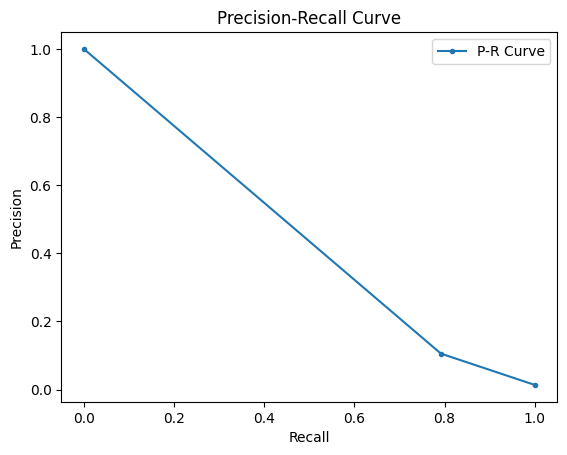

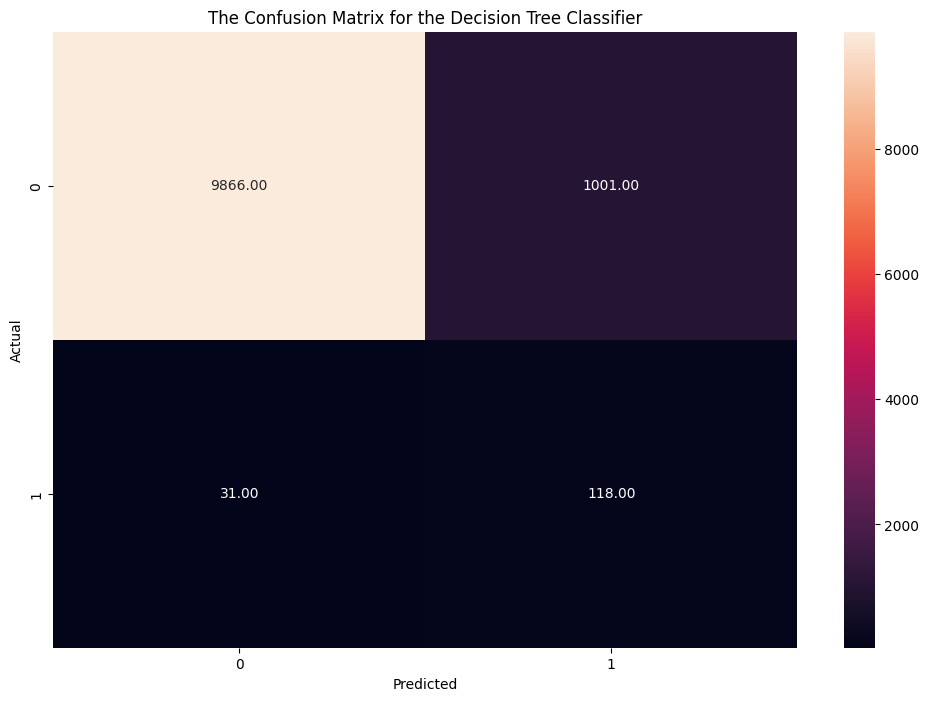

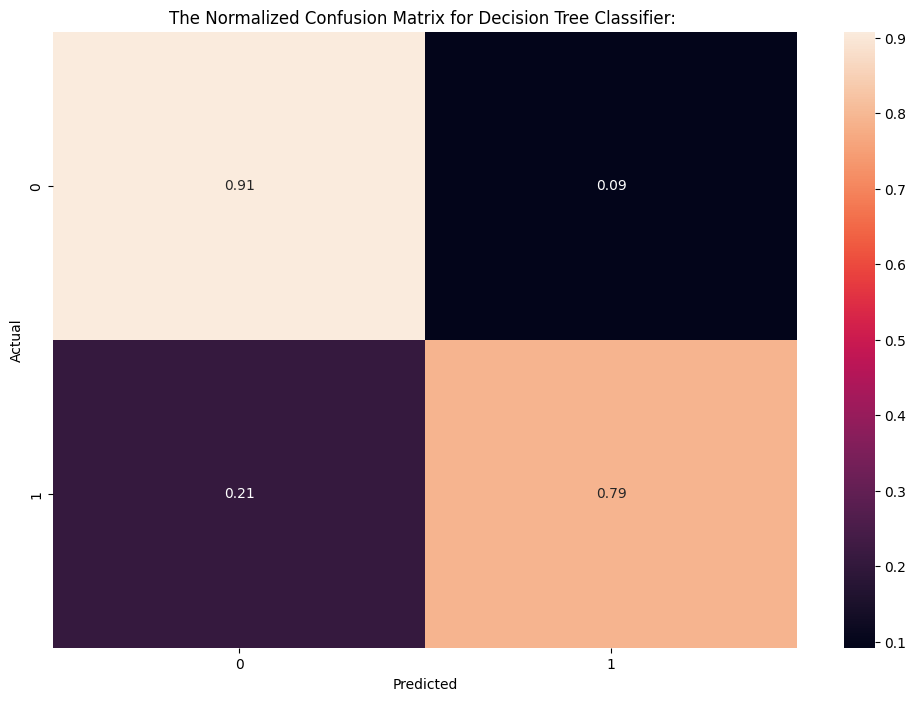

In [120]:
w_train = compute_sample_weight('balanced',y_train_resampled)
# training the model using the oversampled dataset
clf_dt.fit(X_train_resampled,y_train_resampled, sample_weight = w_train)
# testing the model using the imbalanced dataset
y_pred = clf_dt.predict(X_test)
print_metrics("Decision Tree",y_test,y_pred)
print_confusion_matrix("Decision Tree",y_test,y_pred)

For the Random Forest Classifier: 

Accuracy :  0.9241
Precision :  0.5642
Recall :  0.8722
F1 Score :  0.5930


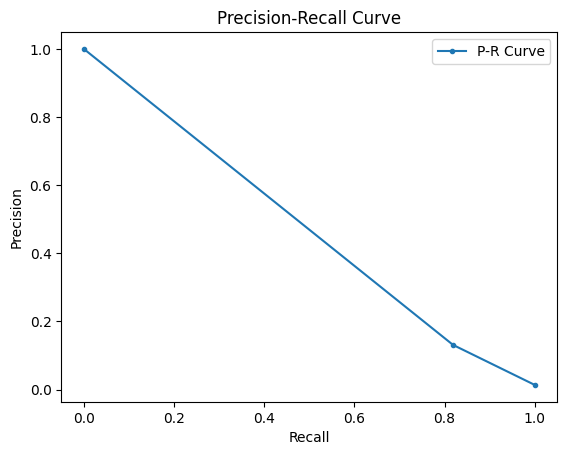

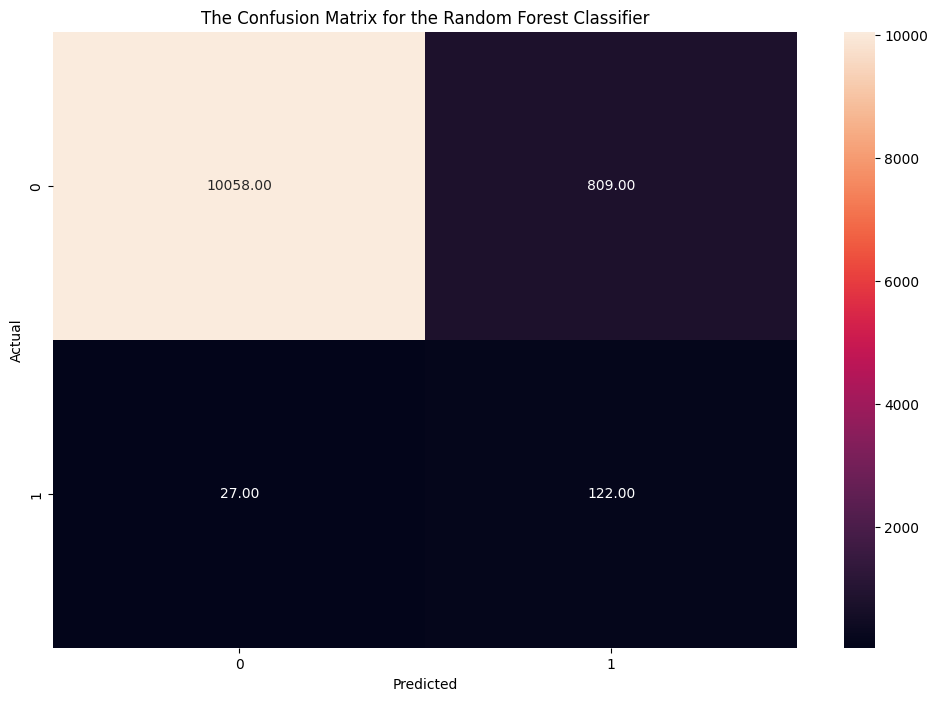

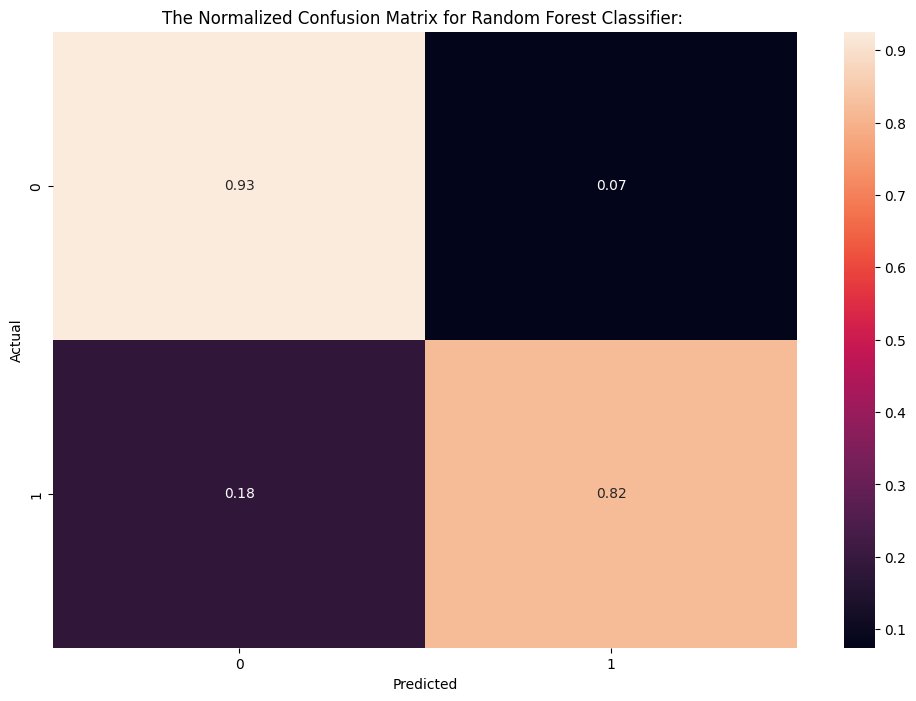

In [121]:
# training the model using the oversampled dataset
clf_rf.fit(X_train_resampled,y_train_resampled, sample_weight = w_train)
# testing the model using the imbalanced dataset
y_pred = clf_rf.predict(X_test)
print_metrics("Random Forest",y_test,y_pred)
print_confusion_matrix("Random Forest",y_test,y_pred)

For the XGBoost Classifier: 

Accuracy :  0.9788
Precision :  0.6801
Recall :  0.8668
F1 Score :  0.7397


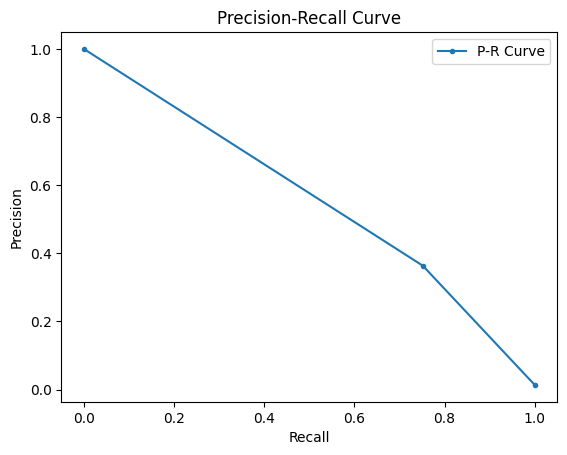

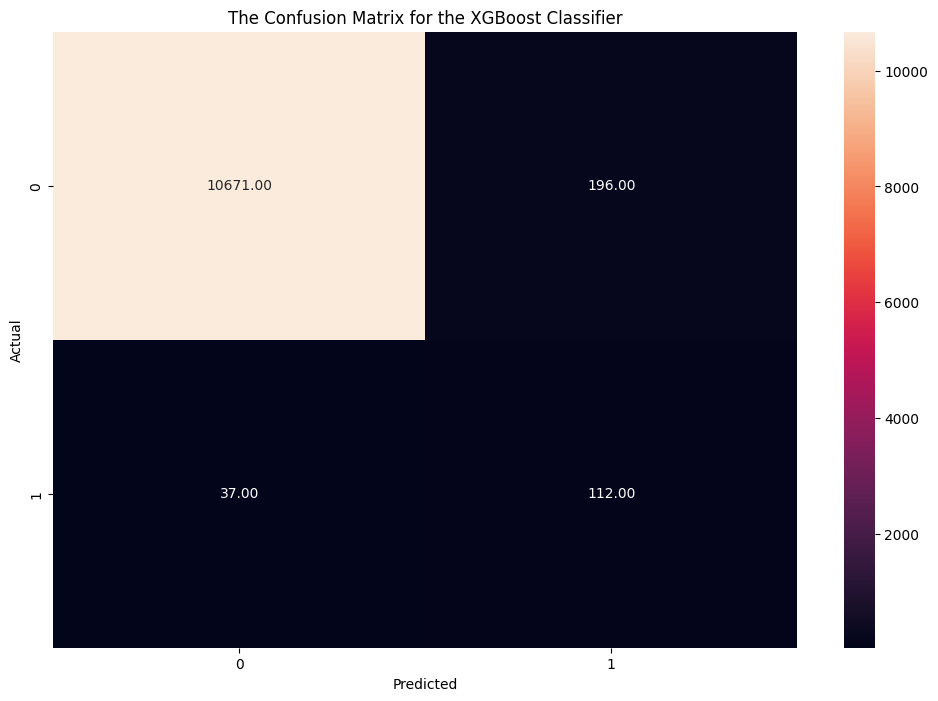

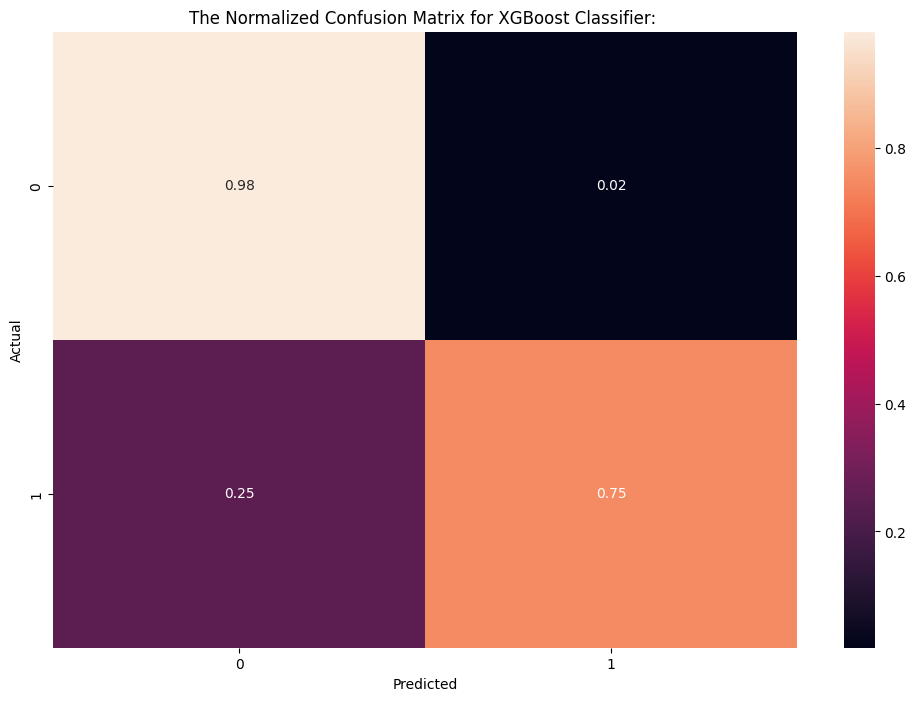

In [122]:
clf_xgb.fit(X_train_resampled,y_train_resampled)
# testing the model using the imbalanced dataset
y_pred = clf_xgb.predict(X_test)
print_metrics("XGBoost",y_test,y_pred)
print_confusion_matrix("XGBoost",y_test,y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']  # keep fixed since you're dealing with imbalance
}
rf = RandomForestClassifier(
    random_state=42
)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',  # or 'roc_auc', 'average_precision' for imbalanced datasets
    cv=3,
    verbose=2,
    n_jobs=-1
)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

y_pred = best_rf.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print_metrics("Random Forest",y_val,y_pred)
print_confusion_matrix("Random Forest",y_val,y_pred)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
